In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import os
from pathlib import Path
import sys

import importlib


# allow imports from src/
PROJECT_ROOT = Path("..").resolve()
sys.path.append(str(PROJECT_ROOT))

# import downloader functions
from src.model.regression_utils import train_model

In [2]:
# Load all data
df_all = pd.read_csv("../data/processed/df_all.csv")
df_all['iso_timestamp'] = pd.to_datetime(df_all['iso_timestamp'], utc=True, format='mixed') # make sure timestamps are UTC

# Change columns to numerics and NaNs if parsing fails
numeric_cols = [
    "channels_in", "channels_out", "channels_unknown", "channels_all",
    "site_temperature", "site_rain_accumulation", "site_snow_accumulation"]
df_all[numeric_cols] = df_all[numeric_cols].apply(pd.to_numeric, errors='coerce')

# Show which cities are in the dataset and how many stations each has
print(f"Loaded {len(df_all):,} total records")
print(f"Cities: {df_all['domain_name'].nunique()}")
print(f"\nAvailable cities:")
for city in sorted(df_all['domain_name'].unique()):
    n_stations = df_all[df_all['domain_name'] == city]['counter_site'].nunique()
    print(f"  {city:40} ({n_stations:2} stations)")

Loaded 6,122,719 total records
Cities: 22

Available cities:
  Landeshauptstadt Stuttgart               (15 stations)
  Landkreis Böblingen                      ( 2 stations)
  Landratsamt Ostalbkreis                  (11 stations)
  Landratsamt Rems-Murr-Kreis              (13 stations)
  Ravensburg Tws Gmbh & Co. Kg             ( 7 stations)
  Regierungspräsidium Stuttgart Aussenstelle Heilbronn ( 1 stations)
  Stadt Bad Säckingen                      ( 2 stations)
  Stadt Freiburg                           (10 stations)
  Stadt Heidelberg                         (15 stations)
  Stadt Heilbronn                          ( 4 stations)
  Stadt Karlsruhe                          ( 1 stations)
  Stadt Kirchheim Unter Teck               ( 1 stations)
  Stadt Konstanz                           ( 6 stations)
  Stadt Ludwigsburg                        (15 stations)
  Stadt Lörrach                            ( 2 stations)
  Stadt Mannheim                           (14 stations)
  Stadt Offenbu

In [3]:
# Load feature data
df_features = pd.read_csv('../data/processed/df_features.csv')

# Ensure timestamps are in datetime format
df_features['iso_timestamp'] = pd.to_datetime(df_features['iso_timestamp'], utc=True)
# sanity check
print(f"Loaded {len(df_features):,} feature records")

Loaded 6,122,719 feature records


In [4]:
# Define cities to process (manually selected just to limit the scope, 
# they have at least a few stations)
cities_to_process = [
    "Stadt Freiburg",
    "Stadt Heidelberg",
    "Landeshauptstadt Stuttgart",
    "Stadt Mannheim",
    "Stadt Reutlingen",
    "Stadt Konstanz",
    "Stadt Tübingen",
    "Stadt Ludwigsburg",
    "Ravensburg Tws Gmbh & Co. Kg"
]

# Outlier threshold (we define outliers as hourly counts above this value)
# we will check if this helps with regression performance
OUTLIER_THRESHOLD = 1000

# summarise and check if its a large amount of outliers
print(f"Will process {len(cities_to_process)} cities")
print(f"Outlier threshold: >{OUTLIER_THRESHOLD} hourly counts")
print(f"Number of detected outliers: {len(df_all[df_all['channels_all'] > OUTLIER_THRESHOLD]):,} ")
print(f"That is {len(df_all[df_all['channels_all'] > OUTLIER_THRESHOLD]) / len(df_all) * 100:.4f}% of all records.")

Will process 9 cities
Outlier threshold: >1000 hourly counts
Number of detected outliers: 10,214 
That is 0.1668% of all records.


In [5]:
################################################
# DATA AVAILABILITY VISUALIZATION              #
################################################
PLOTS_DIR = "../outputs/plots/data_availability"
out_dir = PLOTS_DIR
os.makedirs(out_dir, exist_ok=True)
PROCESSED_DIR = PROJECT_ROOT / "data/processed"

from src.plotting.styles import get_style, latex_escape


for city in cities_to_process:
    print(f"\nProcessing city: {city}")
    # create df for this city
    # Load city data with features
    df_city = pd.read_csv(PROCESSED_DIR / "df_features.csv")
    df_city = df_city[df_city['domain_name'] == city].copy()

    print(f"✓ Loaded {len(df_city):,} hourly records for {city}")
    print(f"✓ {df_city['counter_site'].nunique()} stations")
    print(f"✓ regression_utils.py reloaded")
    # Create pivot table to see when each station has data
    df_pivot_avail = df_city.pivot_table(
        index='iso_timestamp',
        columns='counter_site',
        values='channels_all',
        aggfunc='count'
    )

    # Convert index to datetime to avoid categorical axis issues
    df_pivot_avail.index = pd.to_datetime(df_pivot_avail.index)

    # Convert to binary (1 = has data, 0 = missing)
    df_avail_binary = df_pivot_avail.notna().astype(int)

    # Sample data for visualization (every 24 hours to avoid overplotting)
    df_sample = df_avail_binary.iloc[::24]

    with plt.rc_context(get_style(rel_width=1.5, font_adjustment=0, display_dpi=200)):
        # Plot
        fig, ax = plt.subplots()
        ax.set_facecolor("white")
        fig.patch.set_facecolor("white")

        for i, station in enumerate(df_sample.columns):
            # Create line at y=i when data exists
            times = df_sample.index[df_sample[station] == 1]
            if len(times) > 0:
                ax.scatter(times, [i] * len(times), s=1, alpha=0.5)

        # y-axis labels
        ax.set_yticks(range(len(df_sample.columns)))
        ax.set_yticklabels([latex_escape(s[:30]) for s in df_sample.columns], fontsize=9)

        # x-axis: ensure full time range is shown
        start = df_avail_binary.index.min()
        end = df_avail_binary.index.max()

        # Show start and end timestamps as tick labels
        ax.set_xticks([start, end])
        ax.set_xticklabels(
            [start.strftime("%Y-%m-%d"), end.strftime("%Y-%m-%d")],
            rotation=30
        )

        ax.set_xlabel('Time')
        ax.set_ylabel('Station')
        ax.set_title(f'{latex_escape(city)}: Data Availability Over Time (sampled daily)')
        ax.grid(True, alpha=0.3)
        plt.tight_layout()
        # safe figure named after city 
        # # in directory /plots
        out_path = os.path.join(out_dir, f"data_availability_{city}.pdf")
        plt.savefig(out_path, dpi=300)
        plt.show()

    # Show statistics
    print(f"\nData Availability Summary:")
    print(f"Total time range: {df_avail_binary.index.min()} to {df_avail_binary.index.max()}")
    print(f"Total timestamps: {len(df_avail_binary):,}")
    print(f"\nTimestamps with ALL stations: {df_avail_binary.all(axis=1).sum():,} "
        f"({df_avail_binary.all(axis=1).sum()/len(df_avail_binary)*100:.1f}%)")
    print(f"\nPer-station coverage:")
    for station in df_avail_binary.columns:
        coverage = df_avail_binary[station].sum() / len(df_avail_binary) * 100
        print(f"  {station[:40]:40} {coverage:5.1f}%")

    # --- Sanity check: first & last 7 days ---

    # Full range
    first_ts = df_avail_binary.index.min()
    last_ts  = df_avail_binary.index.max()

    # Window definitions
    start_window_end = first_ts + pd.Timedelta(days=7)
    end_window_start = last_ts  - pd.Timedelta(days=7)

    start_window = df_avail_binary[(df_avail_binary.index >= first_ts) &
                                (df_avail_binary.index <= start_window_end)]

    end_window = df_avail_binary[df_avail_binary.index >= end_window_start]

    # Active if at least one "1" appears in that window
    active_start = list(start_window.columns[start_window.sum(axis=0) > 0])
    inactive_start = list(start_window.columns[start_window.sum(axis=0) == 0])

    active_end = list(end_window.columns[end_window.sum(axis=0) > 0])
    inactive_end = list(end_window.columns[end_window.sum(axis=0) == 0])

    print("\nSanity check:")
    print(f"Start window: {first_ts} → {start_window_end}")
    print(f"  Active stations in first 7 days:   {len(active_start)}")
    print(f"  Inactive stations in first 7 days: {len(inactive_start)}")

    print(f"\nEnd window:   {end_window_start} → {last_ts}")
    print(f"  Active stations in last 7 days:    {len(active_end)}")
    print(f"  Inactive stations in last 7 days:  {len(inactive_end)}")


Processing city: Stadt Freiburg
✓ Loaded 481,718 hourly records for Stadt Freiburg
✓ 10 stations
✓ regression_utils.py reloaded


AttributeError: module 'tueplots.constants.color.rgb' has no attribute 'tue_purple'

In [ ]:
# Function to train model with optional outlier removal
# The actual function that trains the model is in src/model/regression_utils.py

def train_city(df_station, station_name, df_city, remove_outliers=False, threshold=500):
    """
    Train model with option to remove outliers
    
    Returns: results dict with additional 'n_train_samples' field, or None if failed
    """
    if remove_outliers:
        # Filter out outliers from (target) station data
        df_station = df_station[df_station['channels_all'] <= threshold].copy()
        # Also filter city data
        df_city = df_city[df_city['channels_all'] <= threshold].copy()
    
    # make sure we have a reasonable amount of dataa
    if len(df_station) < 1000:
        return None
    

    results, model, features = train_model(df_station, station_name, df_city)
    
    if results is None:
        return None

        
    return results

In [ ]:
################################################
# PROCESS ALL CITIES                           #
################################################

all_city_results = {}

for city_name in cities_to_process:
    print(f"\n{'='*80}")
    print(f"PROCESSING: {city_name}")
    print(f"{'='*80}")
    
    # Get city data only
    df_city = df_features[df_features['domain_name'] == city_name].copy()
    
    if len(df_city) == 0:
        print(f" No data found for {city_name}")
        continue
    
    # count the stations
    stations = df_city['counter_site'].unique()
    print(f"\nStations: {len(stations)}")
    print(f"Records: {len(df_city):,}")
    
    city_results = []
    
    for station_idx, station in enumerate(stations, 1):
        print(f"\n[{station_idx}/{len(stations)}] {station[:50]}")
        
        # Get station data
        df_station = df_city[df_city['counter_site'] == station].copy()
        df_station = df_station.dropna(subset=['channels_all'])
        df_station = df_station.sort_values('iso_timestamp')
        
        if len(df_station) < 1000:
            print(f"     Skipped - only {len(df_station)} records")
            continue
        
        # Train WITHOUT outlier removal
        print("    Training WITH outliers...")
        results_with = train_city(df_station, station, df_city, remove_outliers=False)
        
        if results_with is None:
            print("     Failed to train model with outliers")
            continue
        
        # Train WITH outlier removal
        print("    Training WITHOUT outliers (threshold >", OUTLIER_THRESHOLD, ")...")
        results_without = train_city(df_station, station, df_city, 
                                                      remove_outliers=True, threshold=OUTLIER_THRESHOLD)
        
        if results_without is None:
            print("     Failed to train model without outliers")
            continue
        
        # Combine results
        combined = {
            'city': city_name,
            'station': station,
            'n_features': results_with['n_features'],
            'n_train_samples': results_with['n_train_samples'],
            'n_train_samples_no_outliers': results_without['n_train_samples'],
            # With outliers
            'test_r2_with': results_with['test_r2'],
            'test_rmse_with': results_with['test_rmse'],
            'test_mae_with': results_with['test_mae'],
            'mape_with': results_with['test_mape'],
            # Without outliers
            'test_r2_without': results_without['test_r2'],
            'test_rmse_without': results_without['test_rmse'],
            'test_mae_without': results_without['test_mae'],
            'mape_without': results_without['test_mape'],
            # Difference
            'delta_r2': results_without['test_r2'] - results_with['test_r2']
        }
        
        city_results.append(combined)
        
        print(f"    WITH outliers:    R²={results_with['test_r2']:.4f} | RMSE={results_with['test_rmse']:.2f} | n={results_with['n_train_samples']}")
        print(f"    WITHOUT outliers: R²={results_without['test_r2']:.4f} | RMSE={results_without['test_rmse']:.2f} | n={results_without['n_train_samples']}")
        print(f"    ΔR² = {combined['delta_r2']:+.4f}")
    
    all_city_results[city_name] = city_results
    
    # Print city summary
    if len(city_results) > 0:
        df_city_results = pd.DataFrame(city_results)
        print(f"\n{'-'*80}")
        print(f"SUMMARY - {city_name}")
        print(f"{'-'*80}")
        print(f"Successfully trained models for {len(city_results)} stations")
        print(f"\nAverage R² WITH outliers:    {df_city_results['test_r2_with'].mean():.4f} ± {df_city_results['test_r2_with'].std():.4f}")
        print(f"Average R² WITHOUT outliers: {df_city_results['test_r2_without'].mean():.4f} ± {df_city_results['test_r2_without'].std():.4f}")
        print(f"Average ΔR²:                 {df_city_results['delta_r2'].mean():+.4f} ± {df_city_results['delta_r2'].std():.4f}")

print(f"\n\n{'='*80}")
print("ALL CITIES PROCESSED")
print(f"{'='*80}")


PROCESSING: Stadt Freiburg

Stations: 10
Records: 481,718

[1/10] Wiwilibrücke
    Training WITH outliers...
    Complete coverage: 6,067/112,321 hours (5.4%) → 6,067 samples before features
    After feature cleaning: 6,067 samples (no rows dropped)
    Train period: 2024-05-22 22:00:00+00:00 to 2024-12-11 10:00:00+00:00 (4,853 hours)
    Test period:  2024-12-11 11:00:00+00:00 to 2025-10-31 01:00:00+00:00 (1,214 hours)
    Training WITHOUT outliers (threshold > 1000 )...
    Complete coverage: 5,721/112,270 hours (5.1%) → 5,721 samples before features
    After feature cleaning: 5,721 samples (no rows dropped)
    Train period: 2024-05-22 22:00:00+00:00 to 2024-12-12 10:00:00+00:00 (4,576 hours)
    Test period:  2024-12-12 11:00:00+00:00 to 2025-10-31 01:00:00+00:00 (1,145 hours)
    WITH outliers:    R²=0.9729 | RMSE=53.45 | n=4853
    WITHOUT outliers: R²=0.9709 | RMSE=50.60 | n=4576
    ΔR² = -0.0020

[2/10] FR2 Güterbahn / Ferd.-Weiß-Str.
    Training WITH outliers...
    Compl

In [ ]:
################################################
# DISPLAY RESULTS PER CITY                     #
################################################

for city_name, city_results in all_city_results.items():
    if len(city_results) == 0:
        continue
    
    df_city_results = pd.DataFrame(city_results)
    
    print(f"\n{'='*140}")
    print(f"{city_name} (outlier threshold: >{OUTLIER_THRESHOLD})")
    print(f"{'='*140}")
    
    print(f"\n| Station | R² (with) | RMSE (with) | MAE (with) | MAPE (%) | R² (no outl) | RMSE (no outl) | MAE (no outl) | MAPE (%) | ΔR² | Features | n_train | n_train_no_outl |")
    print(f"|---------|-----------|-------------|------------|----------|--------------|----------------|---------------|----------|-----|----------|---------|-----------------|")
    
    for _, row in df_city_results.iterrows():
        print(f"| {row['station'][:30]:30} | "
              f"{row['test_r2_with']:9.4f} | "
              f"{row['test_rmse_with']:11.2f} | "
              f"{row['test_mae_with']:10.2f} | "
              f"{row['mape_with']:8.2f} | "
              f"{row['test_r2_without']:12.4f} | "
              f"{row['test_rmse_without']:14.2f} | "
              f"{row['test_mae_without']:13.2f} | "
              f"{row['mape_without']:8.2f} | "
              f"{row['delta_r2']:+7.4f} | "
              f"{row['n_features']:8} | "
              f"{row['n_train_samples']:7} | "
              f"{row['n_train_samples_no_outliers']:15} |")
    
    print(f"\nSummary Statistics:")
    print(f"  Outlier threshold:         >{OUTLIER_THRESHOLD} hourly counts")
    print(f"  Avg R² (with outliers):    {df_city_results['test_r2_with'].mean():.4f} ± {df_city_results['test_r2_with'].std():.4f}")
    print(f"  Avg R² (no outliers):      {df_city_results['test_r2_without'].mean():.4f} ± {df_city_results['test_r2_without'].std():.4f}")
    print(f"  Avg ΔR²:                   {df_city_results['delta_r2'].mean():+.4f} ± {df_city_results['delta_r2'].std():.4f}")
    print(f"  Avg RMSE (with outliers):  {df_city_results['test_rmse_with'].mean():.2f} ± {df_city_results['test_rmse_with'].std():.2f}")
    print(f"  Avg RMSE (no outliers):    {df_city_results['test_rmse_without'].mean():.2f} ± {df_city_results['test_rmse_without'].std():.2f}")
    print(f"  Avg MAPE (with outliers):  {df_city_results['mape_with'].mean():.2f}% ± {df_city_results['mape_with'].std():.2f}%")
    print(f"  Avg MAPE (no outliers):    {df_city_results['mape_without'].mean():.2f}% ± {df_city_results['mape_without'].std():.2f}%")



Stadt Freiburg (outlier threshold: >1000)

| Station | R² (with) | RMSE (with) | MAE (with) | MAPE (%) | R² (no outl) | RMSE (no outl) | MAE (no outl) | MAPE (%) | ΔR² | Features | n_train | n_train_no_outl |
|---------|-----------|-------------|------------|----------|--------------|----------------|---------------|----------|-----|----------|---------|-----------------|
| Wiwilibrücke                   |    0.9729 |       53.45 |      38.43 |    25.78 |       0.9709 |          50.60 |         36.41 |    25.80 | -0.0020 |       14 |    4853 |            4576 |
| FR2 Güterbahn / Ferd.-Weiß-Str |    0.9685 |       25.45 |      16.50 |    21.48 |       0.9602 |          25.24 |         16.20 |    22.51 | -0.0083 |       14 |    4853 |            4576 |
| FR1 Dreisam / Otto-Wels-Str.   |    0.8009 |      108.67 |      68.76 |    91.44 |       0.7539 |         108.17 |         68.95 |    96.79 | -0.0470 |       14 |    4853 |            4576 |
| FR3 Eschholzstr. / Egonstr. ei |    0.9525 

In [ ]:
################################################
# HEIDELBERG ONLY (excluding specific station, since otherwise we have no overlap) #
################################################

city_name = "Stadt Heidelberg"
exclude_station = "Ernst-Walz-Brücke West - alt"
# print station names
print(df_features[df_features['domain_name'] == 'Stadt Heidelberg']['counter_site'].unique())


print(f"\n{'='*80}")
print(f"PROCESSING: {city_name} (excluding {exclude_station})")
print(f"{'='*80}")

# Get city data
df_city = df_features[df_features['domain_name'] == city_name].copy()

if len(df_city) == 0:
    print(f"⊗ No data found for {city_name}")
else:
    # Exclude the specific station
    df_city = df_city[df_city['counter_site'] != exclude_station].copy()
    
    print("stations before exclusion:", len(stations))
    stations = df_city['counter_site'].unique()
    print(f"\nStations (after exclusion): {len(stations)}")
    print(f"Records: {len(df_city):,}")
    
    heidelberg_results = []
    
    for station_idx, station in enumerate(stations, 1):
        print(f"\n[{station_idx}/{len(stations)}] {station[:50]}")
        
        # Get station data
        df_station = df_city[df_city['counter_site'] == station].copy()
        df_station = df_station.dropna(subset=['channels_all'])
        df_station = df_station.sort_values('iso_timestamp')
        
        if len(df_station) < 1000:
            print(f"    ⊗ Skipped - only {len(df_station)} records")
            continue
        
        # Train WITHOUT outlier removal
        print("    Training WITH outliers...")
        results_with = train_city(df_station, station, df_city, remove_outliers=False)
        
        if results_with is None:
            print("    ⊗ Failed to train model with outliers")
            continue
        
        # Train WITH outlier removal
        print(f"    Training WITHOUT outliers (threshold >{OUTLIER_THRESHOLD})...")
        results_without = train_city(df_station, station, df_city, 
                                                      remove_outliers=True, threshold=OUTLIER_THRESHOLD)
        
        if results_without is None:
            print("    ⊗ Failed to train model without outliers")
            continue
        
        # Combine results
        combined = {
            'city': city_name,
            'station': station,
            'n_features': results_with['n_features'],
            'n_train_samples': results_with['n_train_samples'],
            'n_train_samples_no_outliers': results_without['n_train_samples'],
            # With outliers
            'test_r2_with': results_with['test_r2'],
            'test_rmse_with': results_with['test_rmse'],
            'test_mae_with': results_with['test_mae'],
            'mape_with': results_with['test_mape'],
            # Without outliers
            'test_r2_without': results_without['test_r2'],
            'test_rmse_without': results_without['test_rmse'],
            'test_mae_without': results_without['test_mae'],
            'mape_without': results_without['test_mape'],
            # Difference
            'delta_r2': results_without['test_r2'] - results_with['test_r2']
        }
        
        heidelberg_results.append(combined)
        
        print(f"    WITH outliers:    R²={results_with['test_r2']:.4f} | RMSE={results_with['test_rmse']:.2f} | n={results_with['n_train_samples']}")
        print(f"    WITHOUT outliers: R²={results_without['test_r2']:.4f} | RMSE={results_without['test_rmse']:.2f} | n={results_without['n_train_samples']}")
        print(f"    ΔR² = {combined['delta_r2']:+.4f}")
    
    # Display results
    if len(heidelberg_results) > 0:
        df_heidelberg = pd.DataFrame(heidelberg_results)
        
        print(f"\n{'='*140}")
        print(f"{city_name} (outlier threshold: >{OUTLIER_THRESHOLD}, excluding {exclude_station})")
        print(f"{'='*140}")
        print(f"\n| Station | R² (with) | RMSE (with) | MAE (with) | MAPE (%) | R² (no outl) | RMSE (no outl) | MAE (no outl) | MAPE (%) | ΔR² | Features | n_train | n_train_no_outl |")
        print(f"|---------|-----------|-------------|------------|----------|--------------|----------------|---------------|----------|-----|----------|---------|-----------------|")
        
        for _, row in df_heidelberg.iterrows():
            print(f"| {row['station'][:30]:30} | "
                  f"{row['test_r2_with']:9.4f} | "
                  f"{row['test_rmse_with']:11.2f} | "
                  f"{row['test_mae_with']:10.2f} | "
                  f"{row['mape_with']:8.2f} | "
                  f"{row['test_r2_without']:12.4f} | "
                  f"{row['test_rmse_without']:14.2f} | "
                  f"{row['test_mae_without']:13.2f} | "
                  f"{row['mape_without']:8.2f} | "
                  f"{row['delta_r2']:+7.4f} | "
                  f"{row['n_features']:8} | "
                  f"{row['n_train_samples']:7} | "
                  f"{row['n_train_samples_no_outliers']:15} |")
        
        print(f"\nSummary Statistics:")
        print(f"  Excluded station:          {exclude_station}")
        print(f"  Outlier threshold:         >{OUTLIER_THRESHOLD} hourly counts")
        print(f"  Avg R² (with outliers):    {df_heidelberg['test_r2_with'].mean():.4f} ± {df_heidelberg['test_r2_with'].std():.4f}")
        print(f"  Avg R² (no outliers):      {df_heidelberg['test_r2_without'].mean():.4f} ± {df_heidelberg['test_r2_without'].std():.4f}")
        print(f"  Avg ΔR²:                   {df_heidelberg['delta_r2'].mean():+.4f} ± {df_heidelberg['delta_r2'].std():.4f}")
        print(f"  Avg RMSE (with outliers):  {df_heidelberg['test_rmse_with'].mean():.2f} ± {df_heidelberg['test_rmse_with'].std():.2f}")
        print(f"  Avg RMSE (no outliers):    {df_heidelberg['test_rmse_without'].mean():.2f} ± {df_heidelberg['test_rmse_without'].std():.2f}")
        print(f"  Avg MAPE (with outliers):  {df_heidelberg['mape_with'].mean():.2f}% ± {df_heidelberg['mape_with'].std():.2f}%")
        print(f"  Avg MAPE (no outliers):    {df_heidelberg['mape_without'].mean():.2f}% ± {df_heidelberg['mape_without'].std():.2f}%")

['Plöck' 'Gaisbergstraße' 'Mannheimer Straße'
 'Ernst-Walz-Brücke Querschnitt' 'Ernst-Walz-Brücke West - alt'
 'Thedor-Heuss-Brücke Querschnitt' 'Rohrbacher Straße Querschnitt'
 'Liebermannstraße' 'Schlierbacher Landstraße' 'Ziegelhäuser Landstraße'
 'Kurfürstenanlage Querschnitt' 'Hardtstraße'
 'Berliner Straße Querschnitt' 'Eppelheimer Str. Querschnitt'
 'Bahnstadtpromenade']

PROCESSING: Stadt Heidelberg (excluding Ernst-Walz-Brücke West - alt)
stations before exclusion: 7

Stations (after exclusion): 14
Records: 820,368

[1/14] Plöck
    Training WITH outliers...
    Complete coverage: 11,555/99,956 hours (11.6%) → 11,555 samples before features
    After feature cleaning: 11,555 samples (no rows dropped)
    Train period: 2020-01-31 23:00:00+00:00 to 2021-03-24 19:00:00+00:00 (9,244 hours)
    Test period:  2021-03-24 20:00:00+00:00 to 2022-05-10 05:00:00+00:00 (2,311 hours)
    Training WITHOUT outliers (threshold >1000)...
    Complete coverage: 11,487/99,955 hours (11.5%) → 11,

In [ ]:
################################################
# OVERALL SUMMARY STATISTICS ACROSS ALL CITIES #
################################################

# Combine all results from all cities
all_results = []
for city_name, city_results in all_city_results.items():
    if len(city_results) > 0:
        all_results.extend(city_results)

# Also include Heidelberg results if available
if 'heidelberg_results' in locals() and len(heidelberg_results) > 0:
    all_results.extend(heidelberg_results)

if len(all_results) > 0:
    df_all_results = pd.DataFrame(all_results)
    
    print(f"\n{'='*120}")
    print(f"OVERALL SUMMARY STATISTICS ACROSS ALL CITIES")
    print(f"{'='*120}")
    print(f"\nTotal stations analyzed: {len(df_all_results)}")
    print(f"Total cities: {df_all_results['city'].nunique()}")
    print(f"Cities: {', '.join(sorted(df_all_results['city'].unique()))}")
    
    # Define metrics to analyze
    metrics = {
        'R² (with outliers)': 'test_r2_with',
        'R² (no outliers)': 'test_r2_without',
        'MAE (with outliers)': 'test_mae_with',
        'MAE (no outliers)': 'test_mae_without',
        'MAPE (with outliers)': 'mape_with',
        'MAPE (no outliers)': 'mape_without',
        'ΔR²': 'delta_r2',
        'Training samples (with outliers)': 'n_train_samples',
        'Training samples (no outliers)': 'n_train_samples_no_outliers'
    }
    
    print(f"\n{'-'*120}")
    print(f"COMPREHENSIVE STATISTICS")
    print(f"{'-'*120}\n")
    
    for metric_name, column_name in metrics.items():
        avg = df_all_results[column_name].mean()
        median = df_all_results[column_name].median()
        min_val = df_all_results[column_name].min()
        max_val = df_all_results[column_name].max()
        
        # Find cities with min and max values
        min_row = df_all_results.loc[df_all_results[column_name].idxmin()]
        max_row = df_all_results.loc[df_all_results[column_name].idxmax()]
        
        print(f"{metric_name}:")
        
        # Format based on metric type
        if 'samples' in metric_name.lower():
            print(f"  Average:  {avg:,.1f}")
            print(f"  Median:   {median:,.1f}")
            print(f"  Min:      {min_val:,.0f}  ({min_row['city']} - {min_row['station'][:40]})")
            print(f"  Max:      {max_val:,.0f}  ({max_row['city']} - {max_row['station'][:40]})")
        elif 'MAPE' in metric_name:
            print(f"  Average:  {avg:.2f}%")
            print(f"  Median:   {median:.2f}%")
            print(f"  Min:      {min_val:.2f}%  ({min_row['city']} - {min_row['station'][:40]})")
            print(f"  Max:      {max_val:.2f}%  ({max_row['city']} - {max_row['station'][:40]})")
        elif 'MAE' in metric_name:
            print(f"  Average:  {avg:.2f}")
            print(f"  Median:   {median:.2f}")
            print(f"  Min:      {min_val:.2f}  ({min_row['city']} - {min_row['station'][:40]})")
            print(f"  Max:      {max_val:.2f}  ({max_row['city']} - {max_row['station'][:40]})")
        else:  # R² and ΔR²
            print(f"  Average:  {avg:.4f}")
            print(f"  Median:   {median:.4f}")
            print(f"  Min:      {min_val:.4f}  ({min_row['city']} - {min_row['station'][:40]})")
            print(f"  Max:      {max_val:.4f}  ({max_row['city']} - {max_row['station'][:40]})")
        print()
    
    # Additional summary: Compare with vs without outliers
    print(f"\n{'-'*120}")
    print(f"IMPACT OF OUTLIER REMOVAL")
    print(f"{'-'*120}\n")
    
    improved = (df_all_results['delta_r2'] > 0).sum()
    degraded = (df_all_results['delta_r2'] < 0).sum()
    unchanged = (df_all_results['delta_r2'] == 0).sum()
    
    print(f"Stations where outlier removal IMPROVED R²:  {improved} ({100*improved/len(df_all_results):.1f}%)")
    print(f"Stations where outlier removal DEGRADED R²:  {degraded} ({100*degraded/len(df_all_results):.1f}%)")
    print(f"Stations where R² remained UNCHANGED:        {unchanged} ({100*unchanged/len(df_all_results):.1f}%)")
    
    print(f"\nAverage improvement in R²: {df_all_results['delta_r2'].mean():+.4f}")
    print(f"Median improvement in R²:  {df_all_results['delta_r2'].median():+.4f}")
    
    # Summary table
    print(f"\n{'-'*120}")
    print(f"QUICK REFERENCE TABLE")
    print(f"{'-'*120}\n")
    
    print(f"{'Metric':<30} | {'With Outliers':<15} | {'Without Outliers':<15} | {'Difference':<15}")
    print(f"{'-'*30}-+-{'-'*15}-+-{'-'*15}-+-{'-'*15}")
    print(f"{'Avg R²':<30} | {df_all_results['test_r2_with'].mean():>15.4f} | {df_all_results['test_r2_without'].mean():>15.4f} | {df_all_results['delta_r2'].mean():>+15.4f}")
    print(f"{'Median R²':<30} | {df_all_results['test_r2_with'].median():>15.4f} | {df_all_results['test_r2_without'].median():>15.4f} | {df_all_results['delta_r2'].median():>+15.4f}")
    print(f"{'Avg MAE':<30} | {df_all_results['test_mae_with'].mean():>15.2f} | {df_all_results['test_mae_without'].mean():>15.2f} | {df_all_results['test_mae_without'].mean() - df_all_results['test_mae_with'].mean():>+15.2f}")
    print(f"{'Median MAE':<30} | {df_all_results['test_mae_with'].median():>15.2f} | {df_all_results['test_mae_without'].median():>15.2f} | {df_all_results['test_mae_without'].median() - df_all_results['test_mae_with'].median():>+15.2f}")
    print(f"{'Avg MAPE (%)':<30} | {df_all_results['mape_with'].mean():>15.2f} | {df_all_results['mape_without'].mean():>15.2f} | {df_all_results['mape_without'].mean() - df_all_results['mape_with'].mean():>+15.2f}")
    print(f"{'Median MAPE (%)':<30} | {df_all_results['mape_with'].median():>15.2f} | {df_all_results['mape_without'].median():>15.2f} | {df_all_results['mape_without'].median() - df_all_results['mape_with'].median():>+15.2f}")
    print(f"{'Avg Training Samples':<30} | {df_all_results['n_train_samples'].mean():>15,.0f} | {df_all_results['n_train_samples_no_outliers'].mean():>15,.0f} | {df_all_results['n_train_samples_no_outliers'].mean() - df_all_results['n_train_samples'].mean():>+15,.0f}")
    print(f"{'Median Training Samples':<30} | {df_all_results['n_train_samples'].median():>15,.0f} | {df_all_results['n_train_samples_no_outliers'].median():>15,.0f} | {df_all_results['n_train_samples_no_outliers'].median() - df_all_results['n_train_samples'].median():>+15,.0f}")
    
else:
    print("No results available for summary statistics.")


OVERALL SUMMARY STATISTICS ACROSS ALL CITIES

Total stations analyzed: 93
Total cities: 9
Cities: Landeshauptstadt Stuttgart, Ravensburg Tws Gmbh & Co. Kg, Stadt Freiburg, Stadt Heidelberg, Stadt Konstanz, Stadt Ludwigsburg, Stadt Mannheim, Stadt Reutlingen, Stadt Tübingen

------------------------------------------------------------------------------------------------------------------------
COMPREHENSIVE STATISTICS
------------------------------------------------------------------------------------------------------------------------

R² (with outliers):
  Average:  0.8013
  Median:   0.8763
  Min:      -0.8114  (Stadt Reutlingen - Metzgerstraße)
  Max:      0.9815  (Stadt Ludwigsburg - Marbacher Straße - Favoritepark)

R² (no outliers):
  Average:  0.8321
  Median:   0.8829
  Min:      -0.1813  (Stadt Mannheim - B38. RI. AUS)
  Max:      0.9815  (Stadt Ludwigsburg - Marbacher Straße - Favoritepark)

MAE (with outliers):
  Average:  15.31
  Median:   9.72
  Min:      2.93  (Stadt Lu

In [ ]:
################################################
# WEATHER FEATURE IMPACT ON DATA AVAILABILITY  #
# (Individual and Combined Analysis)            #
################################################

print(f"\n{'='*80}")
print("WEATHER FEATURE IMPACT ON DATA AVAILABILITY")
print(f"{'='*80}\n")

# Define weather columns
weather_cols = {
    'temperature': 'site_temperature',
    'rain': 'site_rain_accumulation', 
    'snow': 'site_snow_accumulation'
}

# Analyze overall dataset - individual features
print("Individual Weather Feature Availability:")
print(f"{'-'*80}\n")

for feature_name, col_name in weather_cols.items():
    df_with_feature = df_features.dropna(subset=[col_name])
    pct = 100 * len(df_with_feature) / len(df_features)
    lost = len(df_features) - len(df_with_feature)
    
    print(f"{feature_name.capitalize()}:")
    print(f"  Records with data:    {len(df_with_feature):,} ({pct:.1f}%)")
    print(f"  Records without data: {lost:,} ({100-pct:.1f}%)")
    print()

# Combined analysis
print(f"{'-'*80}")
print("Combined Weather Features:")
print(f"{'-'*80}\n")

all_weather = list(weather_cols.values())
df_all_weather = df_features.dropna(subset=all_weather)

print(f"All weather features (temp + rain + snow):")
print(f"  Records with complete data: {len(df_all_weather):,} ({100*len(df_all_weather)/len(df_features):.1f}%)")
print(f"  Records lost:               {len(df_features) - len(df_all_weather):,} ({100*(len(df_features) - len(df_all_weather))/len(df_features):.1f}%)")

# Check combinations
print(f"\nTwo-feature combinations:")
combinations = [
    ('temp + rain', ['site_temperature', 'site_rain_accumulation']),
    ('temp + snow', ['site_temperature', 'site_snow_accumulation']),
    ('rain + snow', ['site_rain_accumulation', 'site_snow_accumulation'])
]

for combo_name, cols in combinations:
    df_combo = df_features.dropna(subset=cols)
    pct = 100 * len(df_combo) / len(df_features)
    print(f"  {combo_name}: {len(df_combo):,} ({pct:.1f}%)")

# Per-city breakdown
print(f"\n{'='*80}")
print("Impact by City (Individual Features):")
print(f"{'='*80}\n")

city_stats = []
for city in cities_to_process:
    df_city = df_features[df_features['domain_name'] == city]
    
    if len(df_city) == 0:
        continue
    
    stats = {
        'city': city,
        'total': len(df_city),
    }
    
    for feature_name, col_name in weather_cols.items():
        df_with = df_city.dropna(subset=[col_name])
        stats[f'{feature_name}_count'] = len(df_with)
        stats[f'{feature_name}_pct'] = 100 * len(df_with) / len(df_city)
    
    # All weather
    df_all = df_city.dropna(subset=all_weather)
    stats['all_weather_count'] = len(df_all)
    stats['all_weather_pct'] = 100 * len(df_all) / len(df_city)
    
    city_stats.append(stats)
    
    print(f"{city}:")
    print(f"  Total records: {len(df_city):,}")
    print(f"  Temperature:   {stats['temperature_count']:,} ({stats['temperature_pct']:.1f}%)")
    print(f"  Rain:          {stats['rain_count']:,} ({stats['rain_pct']:.1f}%)")
    print(f"  Snow:          {stats['snow_count']:,} ({stats['snow_pct']:.1f}%)")
    print(f"  All weather:   {stats['all_weather_count']:,} ({stats['all_weather_pct']:.1f}%)")
    print()

# Summary statistics
df_city_stats = pd.DataFrame(city_stats)

print(f"\n{'='*80}")
print("Summary Statistics Across Cities:")
print(f"{'='*80}\n")

for feature_name in ['temperature', 'rain', 'snow', 'all_weather']:
    avg = df_city_stats[f'{feature_name}_pct'].mean()
    std = df_city_stats[f'{feature_name}_pct'].std()
    min_val = df_city_stats[f'{feature_name}_pct'].min()
    max_val = df_city_stats[f'{feature_name}_pct'].max()
    
    min_city = df_city_stats.loc[df_city_stats[f'{feature_name}_pct'].idxmin(), 'city']
    max_city = df_city_stats.loc[df_city_stats[f'{feature_name}_pct'].idxmax(), 'city']
    
    print(f"{feature_name.replace('_', ' ').capitalize()}:")
    print(f"  Average:  {avg:.1f}% ± {std:.1f}%")
    print(f"  Range:    {min_val:.1f}% ({min_city}) - {max_val:.1f}% ({max_city})")
    print()

# Impact on regression
print(f"\n{'='*80}")
print("Impact on Regression Training Samples:")
print(f"{'='*80}\n")

if len(all_results) > 0:
    df_all_results = pd.DataFrame(all_results)
    total_samples = df_all_results['n_train_samples'].sum()
    
    print(f"Current total training samples: {total_samples:,}")
    print(f"\nEstimated samples if requiring:")
    
    for feature_name in ['temperature', 'rain', 'snow', 'all_weather']:
        avg_pct = df_city_stats[f'{feature_name}_pct'].mean()
        estimated = total_samples * (avg_pct / 100)
        lost = total_samples - estimated
        
        print(f"  {feature_name.replace('_', ' ').capitalize():<15} {estimated:>10,.0f} (lose ~{lost:,.0f}, {100-avg_pct:.1f}%)")


WEATHER FEATURE IMPACT ON DATA AVAILABILITY

Individual Weather Feature Availability:
--------------------------------------------------------------------------------

Temperature:
  Records with data:    5,612,420 (91.7%)
  Records without data: 510,299 (8.3%)

Rain:
  Records with data:    5,612,420 (91.7%)
  Records without data: 510,299 (8.3%)

Snow:
  Records with data:    0 (0.0%)
  Records without data: 6,122,719 (100.0%)

--------------------------------------------------------------------------------
Combined Weather Features:
--------------------------------------------------------------------------------

All weather features (temp + rain + snow):
  Records with complete data: 0 (0.0%)
  Records lost:               6,122,719 (100.0%)

Two-feature combinations:
  temp + rain: 5,612,420 (91.7%)
  temp + snow: 0 (0.0%)
  rain + snow: 0 (0.0%)

Impact by City (Individual Features):

Stadt Freiburg:
  Total records: 481,718
  Temperature:   173,597 (36.0%)
  Rain:          173,5

In [ ]:
################################################
# WEATHER AVAILABILITY AFTER BIKE COUNT FILTER #
################################################

print(f"\n{'='*80}")
print("WEATHER AVAILABILITY AFTER FILTERING TO COMPLETE BIKE COUNTS")
print(f"{'='*80}\n")

# For Heidelberg, exclude problematic station
exclude_heidelberg_station = "Ernst-Walz-Brücke West - alt"

for city in cities_to_process:
    print(f"\n{city}:")
    df_city = df_features[df_features['domain_name'] == city].copy()
    
    # Exclude problematic Heidelberg station
    if city == "Stadt Heidelberg":
        df_city = df_city[df_city['counter_site'] != exclude_heidelberg_station].copy()
        print(f"  (excluding station: {exclude_heidelberg_station})")
    
    # Step 1: Filter to timestamps with complete bike count coverage
    df_pivot_all = df_city.pivot_table(
        index='iso_timestamp',
        columns='counter_site',
        values='channels_all'
    )
    valid_timestamps = df_pivot_all.dropna().index
    df_filtered = df_city[df_city['iso_timestamp'].isin(valid_timestamps)].copy()
    
    print(f"  Original records:               {len(df_city):,}")
    print(f"  After bike count filter:        {len(df_filtered):,} ({100*len(df_filtered)/len(df_city):.1f}%)")
    
    # Step 2: Check weather availability in filtered data
    for feature_name, col_name in weather_cols.items():
        df_with_weather = df_filtered.dropna(subset=[col_name])
        pct = 100 * len(df_with_weather) / len(df_filtered) if len(df_filtered) > 0 else 0
        print(f"    → with {feature_name}:         {len(df_with_weather):,} ({pct:.1f}% of filtered)")
    
    # All weather combined
    df_all_weather = df_filtered.dropna(subset=list(weather_cols.values()))
    pct = 100 * len(df_all_weather) / len(df_filtered) if len(df_filtered) > 0 else 0
    print(f"    → with ALL weather:            {len(df_all_weather):,} ({pct:.1f}% of filtered)")


WEATHER AVAILABILITY AFTER FILTERING TO COMPLETE BIKE COUNTS


Stadt Freiburg:
  Original records:               481,718
  After bike count filter:        60,670 (12.6%)
    → with temperature:         60,670 (100.0% of filtered)
    → with rain:         60,670 (100.0% of filtered)
    → with snow:         0 (0.0% of filtered)
    → with ALL weather:            0 (0.0% of filtered)

Stadt Heidelberg:
  (excluding station: Ernst-Walz-Brücke West - alt)
  Original records:               820,368
  After bike count filter:        161,770 (19.7%)
    → with temperature:         160,955 (99.5% of filtered)
    → with rain:         160,955 (99.5% of filtered)
    → with snow:         0 (0.0% of filtered)
    → with ALL weather:            0 (0.0% of filtered)

Landeshauptstadt Stuttgart:
  Original records:               873,238
  After bike count filter:        677,355 (77.6%)
    → with temperature:         632,198 (93.3% of filtered)
    → with rain:         632,198 (93.3% of filtered)
  

/var/folders/dn/vxwn6zk17qg5wl81t01zs03w0000gn/T/ipykernel_3645/8546320.py:19: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "k--" (-> color='k'). The keyword argument will take precedence.
  ax.plot([-1, 1], [-1, 1],
/var/folders/dn/vxwn6zk17qg5wl81t01zs03w0000gn/T/ipykernel_3645/8546320.py:32: UserWarning: The figure layout has changed to tight
  plt.tight_layout()


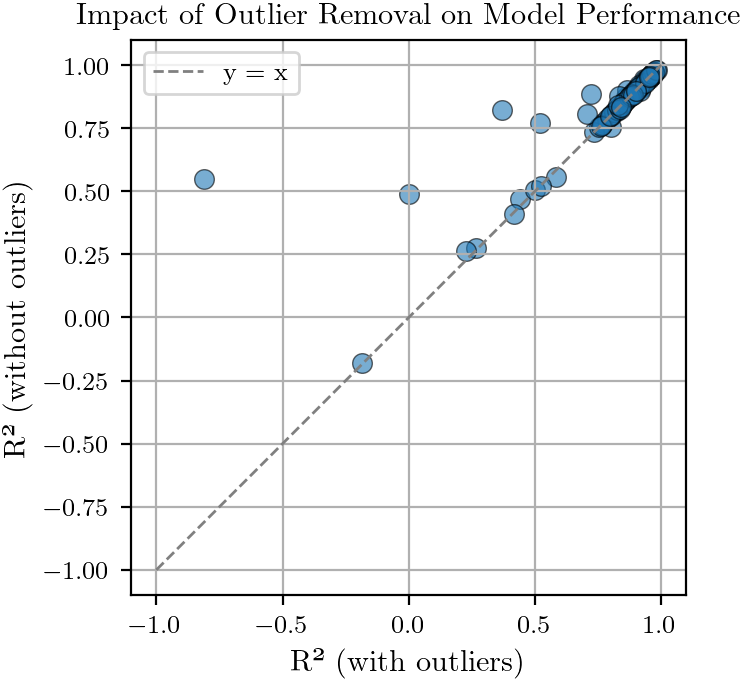


Plot saved to: ../outputs/plots/r2_comparison_with_vs_without_outliers.pdf

Points above the diagonal (y > x): Outlier removal improved R²
Points below the diagonal (y < x): Outlier removal degraded R²


In [ ]:
################################################
# R² COMPARISON PLOT: WITH vs WITHOUT OUTLIERS #
################################################

if len(all_results) > 0:
    df_all_results = pd.DataFrame(all_results)
    
    with plt.rc_context(get_style(rel_width=1.0, font_adjustment=0, display_dpi=200)):
        fig, ax = plt.subplots()
        
        # Scatter plot
        ax.scatter(df_all_results['test_r2_with'], 
                  df_all_results['test_r2_without'],
                  alpha=0.6, s=50, edgecolors='black', linewidth=0.5)
        
        # Diagonal line y = x
        min_val = min(df_all_results['test_r2_with'].min(), df_all_results['test_r2_without'].min())
        max_val = max(df_all_results['test_r2_with'].max(), df_all_results['test_r2_without'].max())
        ax.plot([-1, 1], [-1, 1], 
               'k--', color='gray', linewidth=1, label='y = x')
        
        # Labels and formatting
        ax.set_xlabel('R² (with outliers)')
        ax.set_ylabel('R² (without outliers)')
        ax.set_title('Impact of Outlier Removal on Model Performance')
        ax.legend()
        ax.grid(True)
        
        # Equal aspect ratio to make diagonal truly 45°
        ax.set_aspect('equal', adjustable='box')
        
        plt.tight_layout()
        
        # Save figure
        out_path = os.path.join("../outputs/plots", "r2_comparison_with_vs_without_outliers.pdf")
        os.makedirs(os.path.dirname(out_path), exist_ok=True)
        plt.savefig(out_path, dpi=300)
        plt.show()
        
        print(f"\nPlot saved to: {out_path}")
        print(f"\nPoints above the diagonal (y > x): Outlier removal improved R²")
        print(f"Points below the diagonal (y < x): Outlier removal degraded R²")
else:
    print("No results available for plotting.")